In [1]:
import cv2
import numpy as np
import tensorflow as tf
#from model import Model
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import random
#from google.colab.patches import cv2_imshow

import os 
import json 

In [2]:
def draw_labels(labels,img,show = False):
    
    labels = np.array(labels).astype(int) 
    img = np.array(img).astype(np.uint8)  
    h,w,c  = img.shape
    for bb in labels:
        if max(bb)<=1 and bb.shape[1]!=44:
            y = (bb[[1,3,5,7]]*h).astype(int)
            x = (bb[[0,2,4,6]]*w).astype(int)
            cv2.rectangle(img,(x[0],y[0]),(x[1],y[2]),(0,255,0),2)
        #if bb.shape[0] == 4:
        #    bb_int = bb.astype(int)
        #    cv2.rectangle(img,(bb_int[0],bb_int[1]),(bb_int[2],bb_int[3]),(0,255,0),2)
        else:
            y = (bb[[1,3]]).astype(int)
            x = (bb[[0,2]]).astype(int)
            cv2.rectangle(img,(x[0],y[0]),(x[1],y[1]),(0,255,0),2)
        
    if show:
        plt.figure(figsize = (15,30))
        plt.imshow(img)
    
    return img


def read_json(path):
    f = open(path)
    data = json.load(f)
    f.close()
    return data


def parse_labelme(data,img):
    h,w,c = img.shape
    points = []
    
    def clip(value,top):
        return min(max(value,0),top)
    
    for shapes in data["shapes"]:
        x0,y0 = np.array(shapes["points"])[0]
        x1,y1 = np.array(shapes["points"])[1]

        if x0>x1:
            x1,x0 = x0,x1 

        if y0>y1:
            y1,y0 = y0,y1 
            
        if x1 == x0 or y1 == y0:
            continue

        x1,x0,y1,y0 = clip(x1,w), clip(x0,w), clip(y1,h), clip(y0,h)
        points.append([int(x0), int(y0), int(x1), int(y1)])
    
    return np.array(points)

def labelme_to_tf(data,img):
    h,w,c = img.shape
    points = []
    
    def clip(value):
        return min(max(value,0),1)
    
    for shapes in data["shapes"]:
        x0,y0 = np.array(shapes["points"])[0]
        x1,y1 = np.array(shapes["points"])[1]
        
        if x0>x1:
            x1,x0 = x0,x1 
        
        if y0>y1:
            y1,y0 = y0,y1 
        
        x1,x0,y1,y0 = clip(x1),clip(x0),clip(y1),clip(y0)
        
        if x1 == x0 or y1 == y0:
            continue
        
        points.append([x0/w, y0/h,  x1/w, y0/h, x1/w, y1/h, x0/w, y1/h])
        
    return np.array(points)
    
    
def proportion_to_pixel(img,labels):
    h,w,c  = img.shape
    bb = []
    for proportional_bb in labels:
        #pix_bb = proportional_bb.copy()
        
        y = (proportional_bb[[1,3,5,7]]*h).astype(int)
        x = (proportional_bb[[0,2,4,6]]*w).astype(int)
        x_min, y_min, x_max, y_max = x[0],y[0],x[1],y[2]
        
        bb+=[[x_min, y_min, x_max, y_max]]
        
    return np.array(bb)
        
def pixel_to_proportion(img,labels):
    h,w,c  = img.shape
    bb = []
    for proportional_bb in labels:
        
        #pix_bb = proportional_bb.copy()
        #print("H",h,"W",w,"proportional_bb",proportional_bb)
        
        y = proportional_bb.astype(np.float32)[[0,2]]/h
        
        x = proportional_bb.astype(np.float32)[[0,2]]/w
        

        
        #print(x,y)
        
        x_min, y_min, x_max, y_max = x[0],y[0],x[1],y[1]
        
        if x_min == x_max or y_max == y_min:
            continue
        
        bb+=[[x_min, y_min, x_max, y_max]]
        
    return np.array(bb)
    




In [3]:
import albumentations as A

class Crop:
    def __init__(self,crop_proportions = None):
        self.iters = 0
        
        if crop_proportions is None:
            self.crop_proportions     = [0.6]
            
    def apply(self,img,bboxes,previous_transforms):
        h,w,c  = img.shape
        self.crops = {}
        
        for proportion in self.crop_proportions :

            visibility = 1 if proportion < 0.22 else 0.94 

            self.crops[str(round(proportion,3))] = A.Compose([
                A.RandomCrop(width=int(h*proportion), height=int(h*proportion))
            ],bbox_params = A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=[]))

        
        
        transformations = {}
        
        for proportion,crop in self.crops.items():

            croped = crop(image=img, bboxes=bboxes)
            
            
            tries = 0
            while len(croped["bboxes"])<3 and tries <= 200:
                croped = crop(image=img, bboxes=bboxes)
                tries+=1
                #print(len(croped["bboxes"]),"tries ",tries)
            
            if tries==201:
                print("crop tries exceed 200")
                continue
            #print(len(croped["bboxes"]))
                
            transformations[previous_transforms+"+crop:v"+str(self.iters)+"-p"+str(proportion)] = {"image":croped["image"],"bboxes":croped["bboxes"]}
                
            self.iters+=1
            
        return transformations
            

In [4]:
def padding_img(img):
    h,w,c = img.shape
    h0 = int((h-w)/2)
    hf = int(h0+w)
    delta = abs(h-w)
    if h>w:
        w = h
    else:
        h = w    
    mock = np.zeros((h,w,c))
    mock[int(delta/2):int(w-delta/2),:,:] = img

    detection_frame        = cv2.resize(mock, (320,320), interpolation = cv2.INTER_AREA)
    detection_frame        = np.expand_dims(detection_frame,axis=0).astype(np.uint8)
    return detection_frame




In [5]:
def draw_detection(boxes, classes, scores,mock,threshold=0.5,color = 'r'):
    h,w,c = mock.shape
    color = (255,0,0) if color == 'r' else (0,0,255)
    size  =  2 if color == 'r' else 10
    
    for bb,c,s in zip(boxes, classes, scores):
        if s>threshold:

            '''
            x0,y0 ------
            |          |
            |          |
            |          |
            --------x1,y1
            '''
            
            y0 = int(bb[0]*h)
            x0 = int(bb[1]*w)
            y1 = int(bb[2]*h)           
            x1 = int(bb[3]*w)  
            

            xc = abs(int(x0 + abs(x1-x0)/2)) 
            yc = abs(int(y0 + abs(y1-y0)/2))
            r  = max(int(abs(y1-y0)/2),int(abs(x1-x0)/2)) 
            Xc = xc
            Yc = yc
            
            
            mock = cv2.circle(mock, (xc,yc), r , color, 3)
    return mock

def get_label_boxes(img,bboxes):

    boxes = []
    h,w,c = img.shape
    for bb in bboxes:
        x0 = float(bb[0]/h)
        y0 = float(bb[1]/w)
        x1 = float(bb[2]/h)           
        y1 = float(bb[3]/w)
        boxes.append((y0,x0,y1,x1))

    bboxes    = np.array(boxes)
    scores    = np.array([1]*bboxes.shape[0])
    
    return bboxes,scores


def get_centers(boxes):
    centers = []
    for bb in boxes:

        x0 = float(bb[0])
        y0 = float(bb[1])
        x1 = float(bb[2])           
        y1 = float(bb[3])
        
        xc = round(abs((x0 + abs(x1-x0)/2)),4) 
        yc = round(abs((y0 + abs(y1-y0)/2)),4)

        centers.append((xc,yc))

    return np.array(centers)

In [6]:
def bb_intersection_over_union(boxA, boxB):
    
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [7]:
def get_IoUs(detection_boxes,scores,label_bboxes,threshold = 0.5):

    center_det    = get_centers(detection_boxes[scores>threshold])
    center_labels = get_centers(label_bboxes)
    distances     = np.zeros((center_labels.shape[0],center_det.shape[0]))

    for i, det_c in enumerate(center_det):
        for j,label_c in enumerate(center_labels):
            distances[j,i] = round((((label_c[0]-det_c[0])**2+(label_c[1]-det_c[1])**2)**0.5),3)

    matches = np.argwhere(distances<0.02)

    IoUs = []
    for m in matches:
        label_index,d_index = m
        IoU = bb_intersection_over_union(detection_boxes[d_index],label_bboxes[label_index])
        IoUs.append(IoU)
    
    mean_IoU = sum(IoUs)/len(IoUs) if len(IoUs)> 0 else 0
    detection_accuracy = max(1 - abs(len(detection_boxes[scores>threshold])-len(label_bboxes))/len(label_bboxes),0)
    
    return mean_IoU,detection_accuracy

In [8]:
def get_IoUs(detection_boxes,scores,label_bboxes,confidence_threshold = 0.5,IoU_threshold = 0.5,max_detections = 100):
    
    distances     = np.zeros((len(detection_boxes),len(label_bboxes)))
    for i, det_c in enumerate(detection_boxes):
        if scores[i]>confidence_threshold:
            #print(scores[i])
            for j,label_c in enumerate(label_bboxes):
                distances[i,j] = bb_intersection_over_union(label_bboxes[j],detection_boxes[i])
    #print(i)
    matches = np.argwhere(distances>IoU_threshold)
    #print(distances)
    IoUs = []
    hits = np.array(range(len(label_bboxes)))*0
    
    for m in matches:
        detection_index,label_index = m
        #print(distances[detection_index,label_index])
        IoUs.append(distances[detection_index,label_index])
        hits[label_index]+=1
    
    mean_IoU = sum(IoUs)/len(IoUs) if len(IoUs)> 0 else 0
    detection_accuracy = (hits==1).sum()/(min(len(hits),max_detections))
    
    #max(1 - abs(len(detection_boxes[scores>threshold])-len(label_bboxes))/len(label_bboxes),0)
    #print(hits,detection_accuracy,confidence_threshold,mean_IoU)
    
    return mean_IoU,detection_accuracy

In [9]:
def proportion_to_pixel(img,labels):
    #print("-------------------------------- SHAPE --------------------------------",np.array(labels).shape)
    
    label = np.array(labels)
    h,w,c = img.shape
    if np.array(labels).shape[1]==8:
        label[:,[1,3,5,7]] = label[:,[1,3,5,7]]*h
        label[:,[0,2,4,6]] = label[:,[0,2,4,6]]*w
        label = label.astype(int)
        label = label[:,[1,0,5,2]]

    else:
        label[:,[1,3]] = label[:,[1,3]]*h
        label[:,[0,2]] = label[:,[0,2]]*w
        label = label.astype(int)
        
    return label

def reshape(img,size = 384):
    detection_frame        = cv2.resize(img, (size,size), interpolation = cv2.INTER_AREA)
    detection_frame        = np.expand_dims(detection_frame,axis=0).astype(np.uint8)
    return detection_frame

def draw_detection(boxes, classes, scores,mock, threshold=0.5, color = 'r'):
    h,w,c = mock.shape
    
    
    options = {'red':  (255,0,0),
             'blue': (0,0,255),
             'green':(0,255,0),
             'black':(0,0,0),
             'white':(255,255,255)}
    size  =  2
    
    for bb,c,s in zip(boxes, classes, scores):
        #print(bb)
        if s>threshold:

            '''
            x0,y0 ------
            |          |
            |          |
            |          |
            --------x1,y1
            '''
            
            y0 = int(bb[0])
            x0 = int(bb[1])
            y1 = int(bb[2])           
            x1 = int(bb[3])  
            

            xc = abs(int(x0 + abs(x1-x0)/2)) 
            yc = abs(int(y0 + abs(y1-y0)/2))
            r  = max(int(abs(y1-y0)/2),int(abs(x1-x0)/2)) 
            Xc = xc
            Yc = yc
            
            #mock = mock.astype(np.uint8)
            mock = cv2.circle(mock, (xc,yc), r , options[color], 4)
    return mock

import pandas as pd
from modules.models import EfficientDet as Model 
from tqdm import tqdm


#model          = Model("efficientdet_1_experimento_1/0/1.0.0.tflite")
model         = Model("efficientdet_0/0.0.1.tflite")
#size           = 384
size           = 320
max_detections = 100
df           = pd.read_csv("whole.csv")
test_dataset = df[df.iloc[:,0] == 'TEST']
paths        = test_dataset.iloc[:,1].unique()

mean_detection = []
mean_iou       = []



#for i in tqdm(range(len(paths))):
    
#    if i<320:
#        continue

for path in tqdm(paths):        
    
    if "vertical_horizontal_fliped" in path: continue

    img   = cv2.imread(path)[:,:,::-1].astype(np.uint8)
    h,w,c = img.shape

    if h<w:
        p0     = int(abs((h-w))/2)
        pf     = int(w-p0)
        crop   = img[:,p0:pf,:].copy()
        labels = test_dataset[test_dataset.iloc[:,1] == path].iloc[:,3:]
        bb     = proportion_to_pixel(img.copy(),labels)
        bb[:,[1,3]] = bb[:,[1,3]]-p0

    elif h>w:
        p0     = int(abs((h-w))/2)
        pf     = int(h-p0)
        crop   = img[p0:pf,:,:].copy()
        labels = test_dataset[test_dataset.iloc[:,1] == path].iloc[:,3:]
        bb     = proportion_to_pixel(img.copy(),labels)
        bb[:,[0,2]] = bb[:,[0,2]]-p0
    
    
    mask = np.ones(bb.shape[0])
    for i in range(4):
        mask *= (bb[:,:]>0)[:,i]
    bb = bb[mask.astype(bool),:]

    mask = np.ones(bb.shape[0])
    for i in [0,2]:
        mask *= (bb[:,:]<w)[:,i]
    bb = bb[mask.astype(bool),:]

    mask = np.ones(bb.shape[0])
    for i in [1,3]:
        mask *= (bb[:,:]<h)[:,i]
    bb = bb[mask.astype(bool),:]
    
    if bb.shape[0] == 0:
        print("no labels", path)
        continue
    
    detection_frame = reshape(crop,size)
    detection_boxes, classes, scores = model.predict(detection_frame)
    bb_pred = proportion_to_pixel(crop,detection_boxes)

    metrics = []
    for t in np.linspace(0,1,51).round(3):
        metrics.append(get_IoUs(bb_pred,scores,bb,confidence_threshold = t ,IoU_threshold = 0.65,max_detections = max_detections))
    mean_detection.append(np.array(metrics)[:,1])
    mean_iou.append(np.array(metrics)[:,0])

    #if np.array(metrics)[:,1].max()<0.5:
    print("detection:",np.array(metrics)[:,1].max(),"iou:",np.array(metrics)[:,0].max())
    #print(path)


    

/home/pixlog/install/environments/tf/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-15 08:10:27.605715: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 08:10:27.630073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 08:10:27.723461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be 

KeyboardInterrupt: 

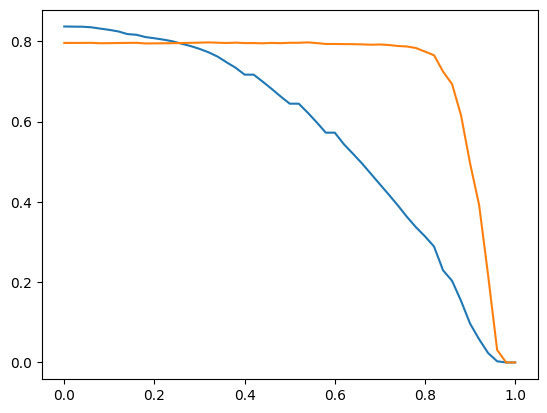

In [18]:
plt.plot(np.linspace(0,1,51).round(3), np.array(mean_detection).mean(axis =0) )
plt.plot(np.linspace(0,1,51).round(3), np.array(mean_iou).mean(axis =0) )

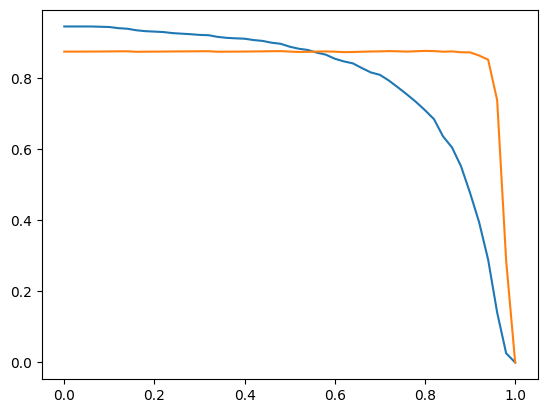

In [12]:
plt.plot(np.linspace(0,1,51).round(3), np.array(mean_detection).mean(axis =0) )
plt.plot(np.linspace(0,1,51).round(3), np.array(mean_iou).mean(axis =0) )

In [19]:
import pandas as pd
df = pd.DataFrame({"trhesholds":np.linspace(0,1,51).round(4),
                  "detection":np.array(mean_detection).mean(axis =0).round(4),
                  "iou":np.array(mean_iou).mean(axis =0).round(4)})

#df.to_csv("0.0.1.csv")

In [183]:
import pandas as pd
df = pd.DataFrame({"trhesholds":np.linspace(0,1,51).round(3),
              "detection":np.array(mean_detection).mean(axis =0),
              "iou":np.array(mean_iou).mean(axis =0)})

,trhesholds,detection,iou
0,0.00,0.771569,0.848755
1,0.02,0.771569,0.848755
2,0.04,0.771569,0.848755
3,0.06,0.771569,0.848755
4,0.08,0.771569,0.848755
5,0.10,0.771569,0.848755
6,0.12,0.771569,0.848755
7,0.14,0.771569,0.848755
8,0.16,0.771569,0.848755
9,0.18,0.771569,0.848755


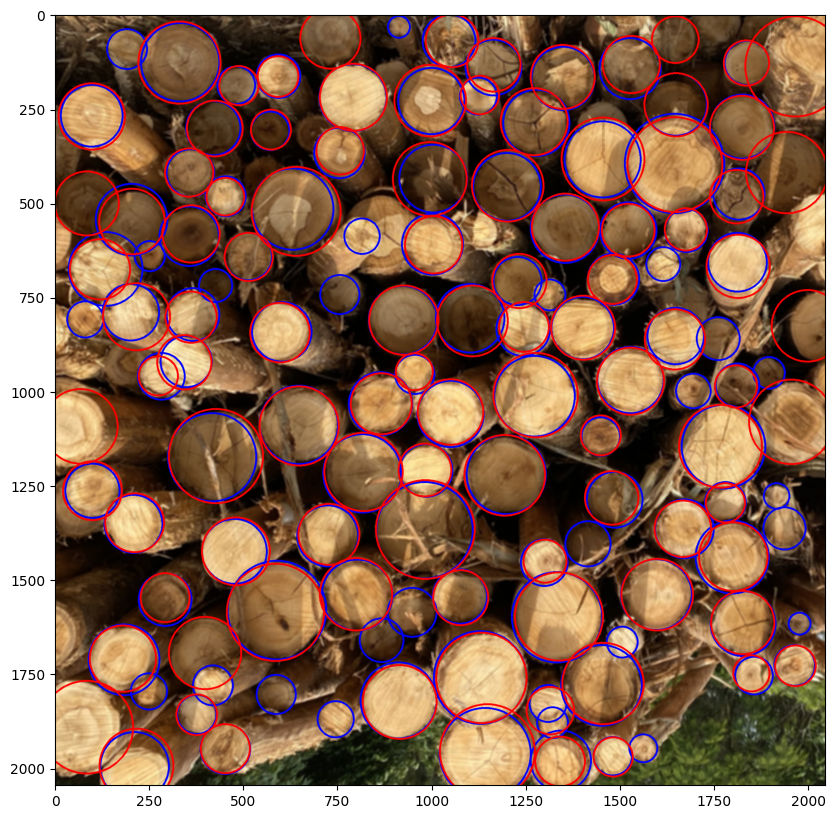

In [11]:
model          = Model("efficientdet_1_experimento_1/0/1.0.0.tflite")
#model         = Model("efficientdet_0/0.0.1.tflite")
size           = 384
#size           = 320
max_detections = 100

df           = pd.read_csv("whole.csv")
test_dataset = df[df.iloc[:,0] == 'TEST']
paths        = test_dataset.iloc[:,1].unique()
path         = paths[715]

img   = cv2.imread(path)[:,:,::-1].astype(np.uint8)
h,w,c = img.shape

if h<w:
    p0     = int(abs((h-w))/2)
    pf     = int(w-p0)
    crop   = img[:,p0:pf,:].copy()
    labels = test_dataset[test_dataset.iloc[:,1] == path].iloc[:,3:]
    bb     = proportion_to_pixel(img.copy(),labels)
    bb[:,[1,3]] = bb[:,[1,3]]-p0

elif h>w:
    p0     = int(abs((h-w))/2)
    pf     = int(h-p0)
    crop   = img[p0:pf,:,:].copy()
    labels = test_dataset[test_dataset.iloc[:,1] == path].iloc[:,3:]
    bb     = proportion_to_pixel(img.copy(),labels)
    bb[:,[0,2]] = bb[:,[0,2]]-p0

    


mask = np.ones(bb.shape[0])
for i in range(4):
    mask *= (bb[:,:]>0)[:,i]
bb = bb[mask.astype(bool),:]


mask = np.ones(bb.shape[0])
for i in [0,2]:
    mask *= (bb[:,:]<w)[:,i]
bb = bb[mask.astype(bool),:]

mask = np.ones(bb.shape[0])
for i in [1,3]:
    mask *= (bb[:,:]<h)[:,i]
bb = bb[mask.astype(bool),:]



if bb.shape[0] == 0:
    print("NO LABELS")
#    continue

detection_frame = reshape(crop,size)
detection_boxes, classes, scores = model.predict(detection_frame)
bb_pred  = proportion_to_pixel(crop,detection_boxes)


mean_detection = []
mean_iou       = []
metrics        = []
for t in np.linspace(0,1,51).round(3):
    metrics.append(get_IoUs(bb_pred,scores,bb,confidence_threshold = t ,IoU_threshold = 0.6))
mean_detection.append(np.array(metrics)[:,1])
mean_iou.append(np.array(metrics)[:,0])

true_scores = [1]*len(bb)
draw_detection(bb, true_scores, true_scores,crop,threshold = 0.5,color = 'blue')
draw_detection(bb_pred, scores, scores,crop,threshold = 0.55,color = 'red')
plt.figure(figsize = (10,10))
plt.imshow(crop)

plt.savefig('new.png')

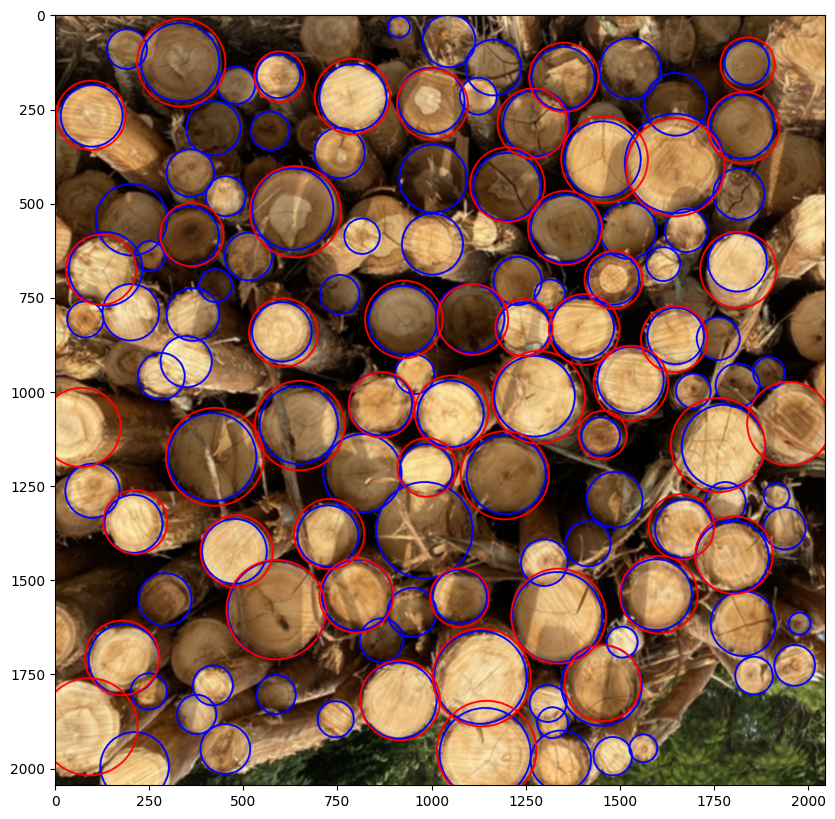

In [13]:
#model          = Model("efficientdet_1_experimento_1/0/1.0.0.tflite")
model         = Model("efficientdet_0/0.0.1.tflite")
#size           = 384
size           = 320
max_detections = 100

df           = pd.read_csv("whole.csv")
test_dataset = df[df.iloc[:,0] == 'TEST']
paths        = test_dataset.iloc[:,1].unique()
path         = paths[715]

img   = cv2.imread(path)[:,:,::-1].astype(np.uint8)
h,w,c = img.shape

if h<w:
    p0     = int(abs((h-w))/2)
    pf     = int(w-p0)
    crop   = img[:,p0:pf,:].copy()
    labels = test_dataset[test_dataset.iloc[:,1] == path].iloc[:,3:]
    bb     = proportion_to_pixel(img.copy(),labels)
    bb[:,[1,3]] = bb[:,[1,3]]-p0

elif h>w:
    p0     = int(abs((h-w))/2)
    pf     = int(h-p0)
    crop   = img[p0:pf,:,:].copy()
    labels = test_dataset[test_dataset.iloc[:,1] == path].iloc[:,3:]
    bb     = proportion_to_pixel(img.copy(),labels)
    bb[:,[0,2]] = bb[:,[0,2]]-p0

    


mask = np.ones(bb.shape[0])
for i in range(4):
    mask *= (bb[:,:]>0)[:,i]
bb = bb[mask.astype(bool),:]


mask = np.ones(bb.shape[0])
for i in [0,2]:
    mask *= (bb[:,:]<w)[:,i]
bb = bb[mask.astype(bool),:]

mask = np.ones(bb.shape[0])
for i in [1,3]:
    mask *= (bb[:,:]<h)[:,i]
bb = bb[mask.astype(bool),:]



if bb.shape[0] == 0:
    print("NO LABELS")
#    continue

detection_frame = reshape(crop,size)
detection_boxes, classes, scores = model.predict(detection_frame)
bb_pred  = proportion_to_pixel(crop,detection_boxes)


mean_detection = []
mean_iou       = []
metrics        = []
for t in np.linspace(0,1,51).round(3):
    metrics.append(get_IoUs(bb_pred,scores,bb,confidence_threshold = t ,IoU_threshold = 0.6))
mean_detection.append(np.array(metrics)[:,1])
mean_iou.append(np.array(metrics)[:,0])

true_scores = [1]*len(bb)
draw_detection(bb, true_scores, true_scores,crop,threshold = 0.5,color = 'blue')
draw_detection(bb_pred, scores, scores,crop,threshold = 0.55,color = 'red')
plt.figure(figsize = (10,10))
plt.imshow(crop)
plt.savefig('old.png')

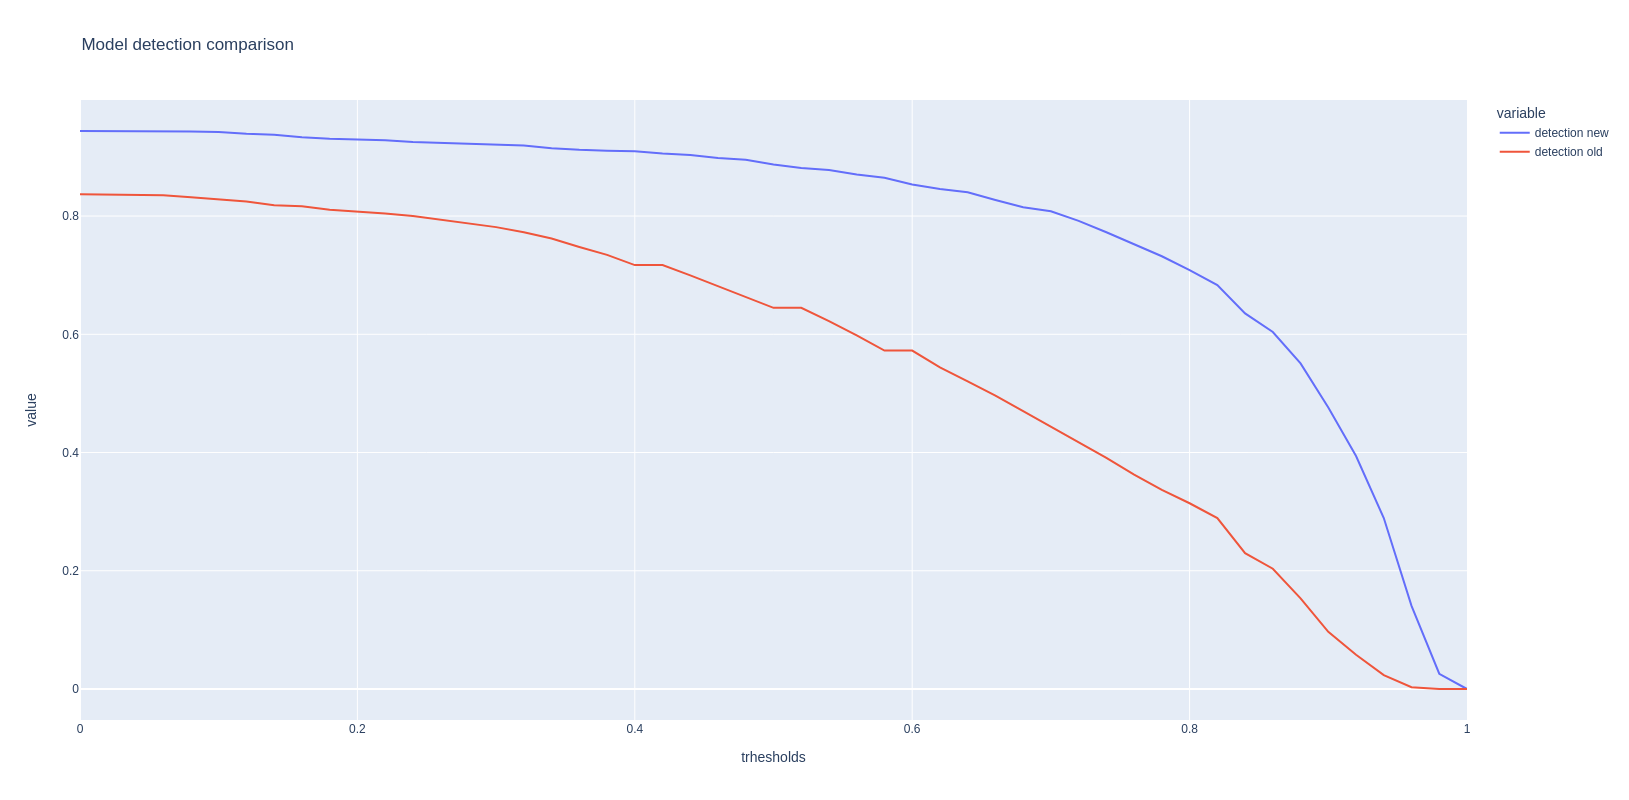

In [79]:
import pandas as pd
df_det_0 = pd.read_csv("1.0.0.csv")
df_det_1 = pd.read_csv("0.0.1.csv")

df_det_0 = df_det_0.rename(columns={"detection": "detection new", "iou":"iou new"})
df_det_1 = df_det_1.rename(columns={"trhesholds":"t","detection": "detection old", "iou": "iou old"})

df = pd.concat([df_det_0,df_det_1],axis = 1)
df = df[["trhesholds","detection new","detection old","iou old","iou new"]]


import plotly.express as px

fig = px.line(df, x="trhesholds", y=["detection new","detection old"], title="Model detection comparison", width=800, height=800)
fig.show()


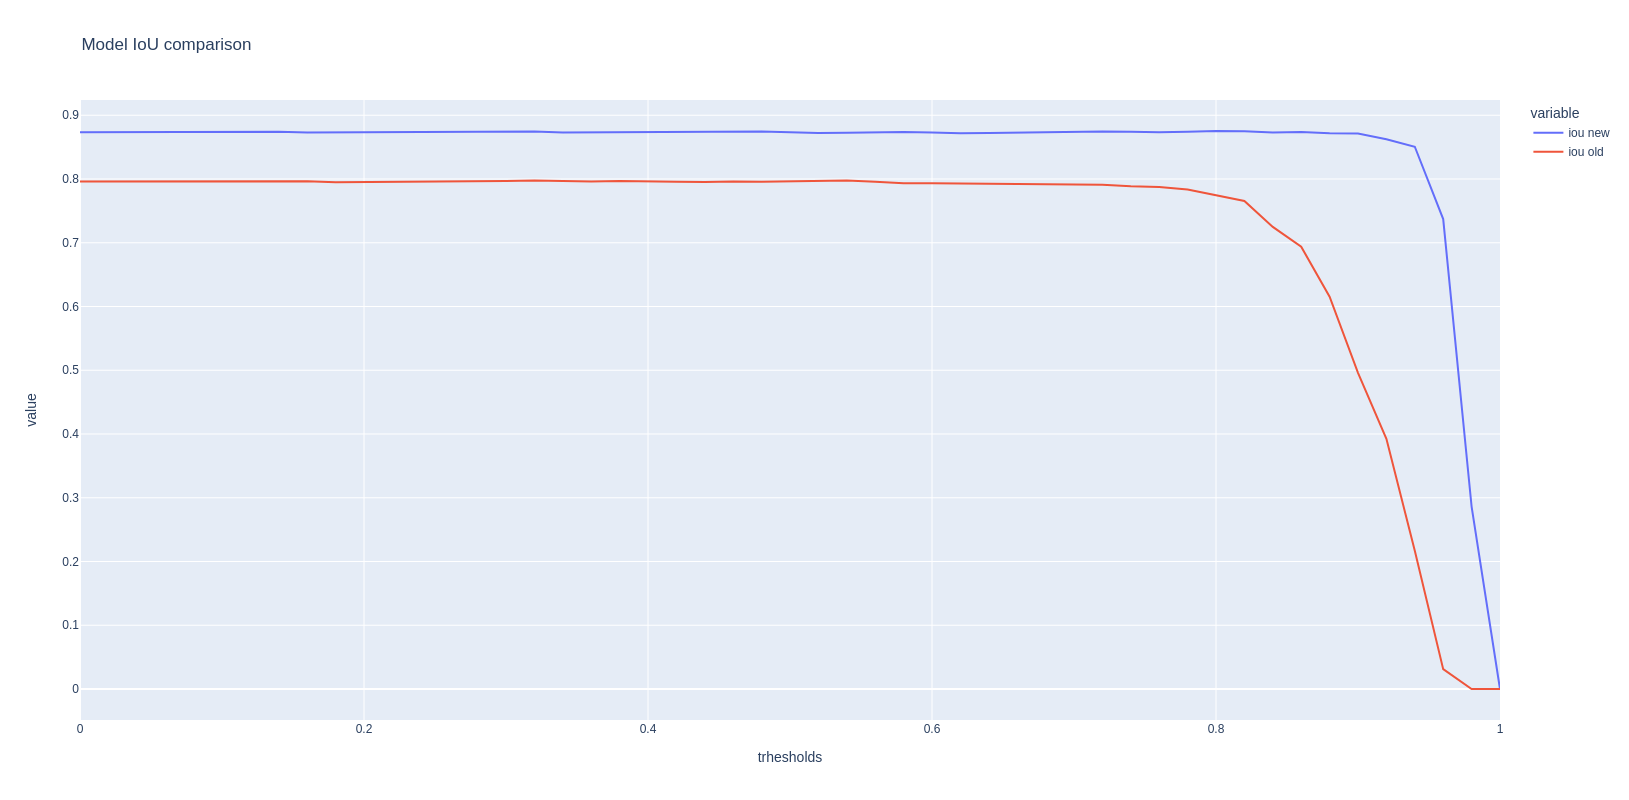

In [80]:
fig = px.line(df, x="trhesholds", y=["iou new","iou old"], title="Model IoU comparison", width=800, height=800)
fig.show()

In [81]:
iou_improve = float((df[df.trhesholds == 0.5]["iou new"] - df[df.trhesholds == 0.5]["iou old"]) / df[df.trhesholds == 0.5]["iou old"])
det_improve = float((df[df.trhesholds == 0.5]["detection new"] - df[df.trhesholds == 0.5]["detection old"]) / df[df.trhesholds == 0.5]["detection old"])

det_improve,iou_improve

(0.3757754342431761, 0.09654739485247955)

In [82]:
(df[df.trhesholds == 0.5]["iou new"] + df[df.trhesholds == 0.5]["detection new"])/2

25    0.88025
dtype: float64

In [83]:
(df[df.trhesholds == 0.5]["iou old"] + df[df.trhesholds == 0.5]["detection old"])/2

25    0.72065
dtype: float64

In [89]:
model           = Model("efficientdet_1_experimento_1/0/model.tflite")
crop            = Crop()
img             = cv2.imread(labels[0])[:,:,::-1]
labels          = df[df.iloc[:,1] == labels[0]].iloc[:,3:]
labels          = parse_labelme(data,img)
labels          = proportion_to_pixel(img,labels)
tests           = crop.apply(img,labels,'_')
raw             = tests['_+crop:v0-p0.6']["image"] 
detection_frame = reshape(raw)

label_bboxes,label_scores    = get_label_boxes(tests["_+crop:v0-p0.6"]["image"], tests["_+crop:v0-p0.6"]["bboxes"])

detection_boxes, classes, scores = model.predict(detection_frame)
detection_frame[0]     = draw_detection(detection_boxes, classes, scores,detection_frame[0],threshold = 0.5)
get_IoUs(detection_boxes,scores,label_bboxes,threshold = 0.47)


KeyError: 0

In [61]:
from tqdm import tqdm 

all_IoUs  = []
all_dets  = []
tresholds = []
paths     = generate_all_label_paths()

for path in tqdm(paths):
    img                 = cv2.imread(path)[:,:,::-1]
    detection_frame     = self.reshape(img)
    label_bboxes,scores = self.get_labels(self.df,path)
    detection_boxes, classes, scores = model.predict(detection_frame)
    IoUs = []
    dets = []
    for t in np.linspace(0,1,50):
        IoU,det = self.get_IoUs(detection_boxes,scores,label_bboxes,threshold = t)
        IoUs.append(IoU)
        dets.append(det)

    all_IoUs.append(np.array(IoUs))
    all_dets.append(np.array(dets))

tresholds = np.linspace(0,1,50).tolist()
mean_iou  = np.array(all_IoUs).mean(axis = 0)
mean_det  = np.array(all_dets).mean(axis = 0)

  0%|                                                    | 0/76 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
from tqdm import tqdm 

all_IoUs  = []
all_dets  = []
tresholds = []
paths     = generate_all_label_paths()

for path in tqdm(paths):
    img                 = cv2.imread(path)[:,:,::-1]
    detection_frame     = self.reshape(img)
    label_bboxes,scores = self.get_labels(self.df,path)
    detection_boxes, classes, scores = model.predict(detection_frame)
    IoUs = []
    dets = []
    for t in np.linspace(0,1,50):
        IoU,det = self.get_IoUs(detection_boxes,scores,label_bboxes,threshold = t)
        IoUs.append(IoU)
        dets.append(det)

    all_IoUs.append(np.array(IoUs))
    all_dets.append(np.array(dets))

tresholds = np.linspace(0,1,50).tolist()
mean_iou  = np.array(all_IoUs).mean(axis = 0)
mean_det  = np.array(all_dets).mean(axis = 0)

In [43]:
def get_metrics(image,path = "models/model-det-400.tflite"):
    
    model = Model(path)
    for key in image:
        
        raw                       = image[key]["image"]
        detection_frame           = reshape(raw)
        label_bboxes,label_scores = get_label_boxes(image[key]["image"], image[key]["bboxes"])
        
        
        detection_boxes, classes, scores = model.predict(detection_frame)
        
        IoUs = []
        dets = []
        tresholds = []
        for t in np.linspace(0,1,50):
            IoU,det = get_IoUs(detection_boxes,scores,label_bboxes,threshold = t)
            IoUs.append(IoU)
            dets.append(det)
            tresholds.append(t)
            #metrics.append((t,IoU,det))

    return np.array(IoUs), np.array(dets), np.array(tresholds)



In [10]:
import os 
from random import shuffle

def generate_all_label_paths():
    
    folders =   ['CENIBRA']

    label_paths = []

    for folder in folders:
        files = os.listdir(folder)
        for file in files:
            if ".json" in file:
                label_paths.append(folder+"/"+file)

    for label in label_paths:
        image_path = label.replace(".json",".jpg")
        
    return label_paths

In [45]:
img    = cv2.imread(image_path)
data   = read_json(label_paths)
labels = parse_labelme(data,img)
bboxes = pixel_to_proportion(img,labels)

In [12]:
labels

array(['augumentations/remasa_ibema26.11/raw_remasa_ibema26.11_IMG_3682.85_RAW.jpg',
       'augumentations/remasa_ibema26.11/raw_remasa_ibema26.11_IMG_3682.85_vertical_horizontal_fliped.jpg',
       'augumentations/remasa_ibema26.11/raw_remasa_ibema26.11_IMG_3682.85_RAW+crop:v0-p0.639.jpg',
       ...,
       'augumentations/CENIBRA_3/raw_CENIBRA_3_IMG_6322_vertical_horizontal_fliped+crop:v3-p0.338+color.jpg',
       'augumentations/CENIBRA_3/raw_CENIBRA_3_IMG_6322_vertical_horizontal_fliped+crop:v3-p0.338+change.jpg',
       'augumentations/CENIBRA_3/raw_CENIBRA_3_IMG_6322_vertical_horizontal_fliped+crop:v3-p0.338+noise.jpg'],
      dtype=object)

In [11]:
labels = generate_all_label_paths()

shuffle(labels)

all_ious = []
all_dets = []

for label_paths in labels:
    try:
    
        image_path = label_paths.replace(".json",".jpg")
        root       = label_paths.replace(".json","").replace("/","_")

        img    = cv2.imread(image_path)[:,:,::-1]

        data   = read_json(label_paths)
        labels = parse_labelme(data,img)
        #tests  = crop.apply(img,labels,'_')

        IoUs, dets, tresholds = get_metrics(tests,path ="models/model-det-400.tflite") 

        all_ious.append(IoUs)
        all_dets.append(dets)
    
    except Exception as e:
        print(e)
        break
 
    

name 'get_metrics' is not defined


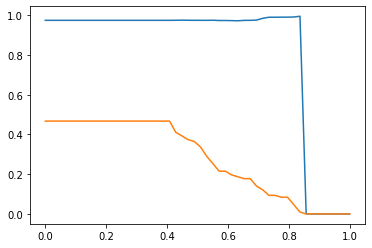

In [52]:
plt.plot(tresholds,np.array(all_ious).mean(axis = 0))
plt.plot(tresholds,np.array(all_dets).mean(axis = 0))

In [55]:
metrics = get_metrics(tests,path ="models/model-det-400.tflite") 
plt.plot(np.array(metrics)[:,0] , np.array(metrics)[:,1])
plt.plot(np.array(metrics)[:,0] , np.array(metrics)[:,2])
plt.legend(["IoU","detection accuracy"])
print(np.array(metrics)[:,1].max())

UnboundLocalError: local variable 'IoUs' referenced before assignment

In [13]:
center_det    = get_centers(detection_boxes)
center_labels = get_centers(label_bboxes)
IoUs          = np.zeros((center_labels.shape[0],center_det.shape[0]))

for i, det_bb in enumerate(detection_boxes):
    for j,label_bb in enumerate(label_bboxes):
        IoUs[j,i] = bb_intersection_over_union(det_bb,label_bb)

matches = np.argwhere(IoUs>.95)


raw                    = tests['_+crop:v0-p0.6']["image"]
detection_frame        = reshape(raw)
detection_boxes, classes, scores = model.predict(detection_frame)
label_bboxes,scores    = get_label_boxes(tests["_+crop:v0-p0.6"]["image"], tests["_+crop:v0-p0.6"]["bboxes"])

img_drawn              = draw_detection(detection_boxes, classes, scores,detection_frame[0] ,threshold=0.5,color = 'blue')
img_drawn              = draw_detection(label_bboxes, classes, scores,img_drawn ,threshold=0.5)

plt.imshow(img_drawn)

KeyError: '_+crop:v0-p0.6'

In [162]:
label_bboxes,scores = get_label_boxes(tests["_+crop:v0-p0.3"]["image"], tests["_+crop:v0-p0.3"]["bboxes"])
   
boxes,conf = get_label_boxes(img,bboxes)
#get_centers(boxes)

boxes

KeyError: '_+crop:v0-p0.3'

In [423]:
detection_frame        = tests['_+crop:v0-p0.2']["image"]
detection_frame        = reshape(detection_frame)
boxes, classes, scores = model.predict(detection_frame)

img_drawn              = draw_labels(tests['_+crop:v0-p0.2']["bboxes"],detection_frame[0],True)

mock = draw_detection(boxes, classes, scores,detection_frame[0],threshold=0.5)
plt.imshow(detection_frame[0].astype(np.uint))

KeyError: '_+crop:v0-p0.2'